In [1]:
import networkx as nx
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
import scipy.stats as stats

import numpy as np
import random as rd
import statistics as st
import copy
import time

Creazione del grafo

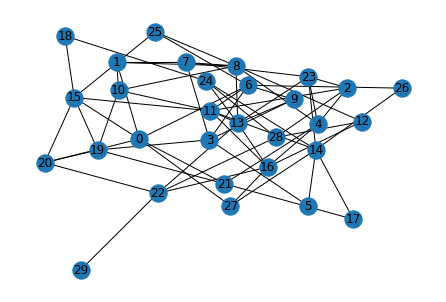

In [2]:
N = 30
P = 0.15

G = nx.erdos_renyi_graph(N, P)
while min([d for n, d in G.degree()]) < 1:
    G = nx.erdos_renyi_graph(N, P)

nodes = sorted([int(n) for n in G.nodes])
nx.draw(G, with_labels=True)    

Analisi spettrale del grafo iniziale

In [3]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)]

for a, b in adjacency :
    a = int(a)
    for c in b :
        c = int(c)
        A[a][c] = 1

k_0 = [sum(A[n]) for n in range(N)]

Definizione della matrice stocastica e di quella laplaciana con calcolo di autovalori e autovettori della laplaciana.

In [4]:
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    for c in b: 
        P[a][c] = 1./G.degree[a]

matrixP = np.array(P)
        
matrixL = np.identity(N) - matrixP

autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)

minDiff = min([np.abs(autovaloriL[i]) for i in range(N)])
for i in range(N):
    if np.abs(autovaloriL[i]) == minDiff:
        pS = autovettoriL[i]
        FiedlerEigenvalues = list(autovaloriL)
        FiedlerEigenvalues.remove(autovaloriL[i])
        print("Eigenvector found")
        break

if pS[0] < 0:
    pS = -pS
    
pS = pS.real

pSNorm = [h/sum(pS) for h in pS]

Eigenvector found


Dinamica di random walk sul grafo iniziale iniziale

In [5]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[int(new_node)] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[int(n)]
    history += [evolution]

In [6]:
walker_per_node = 2500
time_steps = int(50)

long_history = [[walker_per_node] * len(G.nodes)]

In [7]:
t0 = time.time()

for n in G.nodes:
    G.nodes[n]['N_i'] = walker_per_node
    
for t in range(time_steps):
    dynamic_evolution(G, long_history)

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 42.51141095161438 seconds


Rimozione di un link

Links removed are: [[8, 13], [17, 14], [10, 19], [1, 7], [0, 21], [8, 1], [8, 4], [9, 6], [26, 6], [11, 15]]


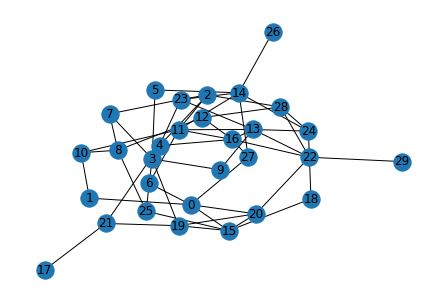

In [8]:
links = []
for r in range(10):
    links += [list(_random_subset(G.nodes, 2, seed))]
    while links[r] not in G.edges or len(G[links[r][0]]) == 1 or len(G[links[r][1]]) == 1:
        links[r] = list(_random_subset(G.nodes, 2, seed))
    G.remove_edge(links[r][0], links[r][1])

print('Links removed are:', links)

nx.draw(G, with_labels=True)

In [9]:
adjacency_r = list(G.adjacency())
A_r = []
for a, b in adjacency_r :
    A_r += [[0]*len(adjacency_r)]

for a, b in adjacency_r :
    a = int(a)
    for c in b :
        c = int(c)
        A_r[a][c] = 1

k_r = [sum(A_r[n]) for n in range(N)]

Definizione della matrice stocastica e di quella laplaciana con calcolo di autovalori e autovettori della laplaciana.

In [10]:
P_r = []
for a, b in adjacency_r :
    P_r += [[0]*len(adjacency_r)]
    for c in b: 
        P_r[a][c] = 1./G.degree[a] 
        
matrixP_r = np.array(P_r)

matrixL_r = np.identity(N) - matrixP_r

autovaloriL_r, autovettoriL_r = np.linalg.eig(np.transpose(matrixL_r))
autovettoriL_r = np.transpose(autovettoriL_r)

minDiff = min([np.abs(autovaloriL_r[i]) for i in range(N)])
for i in range(N):
    if np.abs(autovaloriL_r[i]) == minDiff:
        pS_r = autovettoriL_r[i]
        FiedlerEigenvalues_r = list(autovaloriL)
        FiedlerEigenvalues_r.remove(autovaloriL[i])
        print("Eigenvector found")
        break

if pS_r[0] < 0:
    pS_r = -pS_r

pSNorm_r = [h/sum(pS_r) for h in pS_r]

Eigenvector found


Dinamica di random walk dopo la rottura dei links.

In [11]:
t0 = time.time()

for t in range(time_steps):
    dynamic_evolution(G, long_history)

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 38.41956853866577 seconds


Dinamica ottimizzata con l'impiego dell'algoritmo di Metropolis.

In [12]:
seed = np.random.RandomState()
def dynamic_evolution_metropolis(G, A_r, history = []):
    evolution = [0] * len(G.nodes)
    P_f = copy.deepcopy(A_r)
    
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            
            f_i = k_0[n]/k_r[n]
            
            new_node = _random_subset(neighbours, 1, seed).pop()
            f_j = k_0[new_node]/k_r[new_node]
            
            p_ij = min(1,f_j/f_i)
            P_f[n][new_node] = p_ij / len(neighbours)
            if rd.random() <= p_ij:
                evolution[int(new_node)] += 1  
            else:
                evolution[n] += 1
            
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[int(n)]
    history += [evolution]
    
    return P_f

In [13]:
t0 = time.time()

for t in range(time_steps):
    P_f = dynamic_evolution_metropolis(G, A_r, long_history)

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 41.73453068733215 seconds


In [14]:
norm = max([sum(P_f[i]) for i in range(N)])
for i in range(N):
    P_f[i][i] = norm - sum(P_f[i])

In [15]:
matrixP_f = np.array(P_f)

matrixL_f = norm*np.identity(N) - matrixP_f

autovaloriL_f, autovettoriL_f = np.linalg.eig(np.transpose(matrixL_f))
autovettoriL_f = np.transpose(autovettoriL_f)
print('autovalori di L_f:', autovaloriL_f)

minDiff = min([np.abs(autovaloriL_f[i]) for i in range(N)])
for i in range(N):
    if np.abs(autovaloriL_f[i]) == minDiff:
        pS_f = autovettoriL_f[i]
        print("Eigenvector found")
        break

if pS_f[0] < 0:
    pS_f = -pS_f

pS_f = pS_f.real
    
pSNorm_f = [h/sum(abs(pS_f)) for h in pS_f]

autovalori di L_f: [-4.44089210e-16  1.72381573e+00  2.08039697e-01  2.31683589e-01
  1.61308782e+00  1.59104305e+00  1.52468880e+00  1.49577093e+00
  1.45879566e+00  1.41911964e+00  3.06492157e-01  3.24134043e-01
  3.65766563e-01  4.37278843e-01  5.17665681e-01  5.38819792e-01
  5.81687444e-01  6.77743249e-01  6.87899077e-01  7.35970957e-01
  7.71257129e-01  1.30235045e+00  1.26496628e+00  1.21765601e+00
  1.18061059e+00  1.08544939e+00  8.68002227e-01  9.23010936e-01
  1.02270447e+00  1.00972790e+00]
Eigenvector found


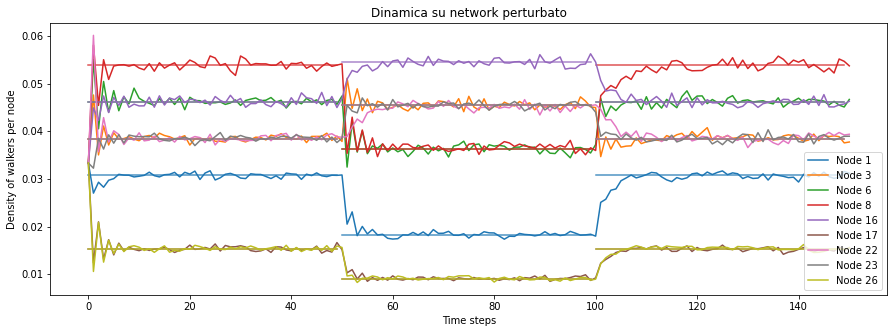

In [19]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15, 5))
node = []
# color = list(mcolors.CSS4_COLORS)
color = list(mcolors.TABLEAU_COLORS)

for n in G.nodes:
    if abs(pSNorm_r[n] - pSNorm[n]) > 0.006:
        node += [n]

time_range = long_history
index = np.arange(0, len(time_range), 1)
index1 = np.arange(0, time_steps, 1)
index2 = np.arange(time_steps, 2*time_steps, 1)
index3 = np.arange(2*time_steps, 3*time_steps, 1)

col = 0
for i in node:
    ax.plot(index, [time_range[ind][i]/walker_per_node/N for ind in index],
            label = f"Node {i}",
            color = color[col])
    ax.plot(index1, [pSNorm[i]]*len(index1),
            color = color[col], alpha = 0.8)
    ax.plot(index2, [pSNorm_r[i]]*len(index2),
            color = color[col], alpha = 0.8)
    ax.plot(index3, [pSNorm_f[i]]*len(index2),
            color = color[col], alpha = 0.8)
    col += 1
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.set_title("Dinamica su network perturbato")

ax.legend()

plt.show()

In [17]:
diff = [abs(pSNorm_f[i] - pSNorm[i]) for i in range(N)]
sum(diff)

1.182214048878194e-15